In [1]:
from configparser import ConfigParser, ExtendedInterpolation

import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import pyspike
import os
import joblib

import multiprocessing as mp

from ipywidgets import IntSlider, interact, Dropdown, fixed
from spikelib import spiketools as spkt

import scipy.cluster as cluster
import scipy.spatial.distance as distance
from scipy.spatial.distance import squareform
import sklearn.metrics.cluster as metrics
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from tqdm import tqdm
from chirp import get_chirp_subevents, get_pop_response, chirp_def_args
import json

%matplotlib inline
config = ConfigParser(interpolation=ExtendedInterpolation())

In [2]:
rootdir = os.getcwd()
with open("params.json") as p:
    params = json.load(p)
    
# Create output folder if it does not exist
if os.path.isdir(params['Output']) == False:
    os.mkdir(params['Output'])

In [3]:
exp_unit = [[], [], [], []]
spiketimes_grp = [[], [], [], []]
chirp_psth = [[], [], [], []]
flash_psth = [[], [], [], []]
pcells = None

ctype_map = {'ON': 0, 'OFF': 1, 'ON/OFF': 2, 'Null': 3}

for exp_path in params['Experiments']:
    os.chdir(exp_path)
    cfg_file = 'config.ini'
    config.read(cfg_file)
    
    config.set('PROJECT', 'path', '{}/'.format(os.getcwd()))
    with open(cfg_file, 'w+') as configfile:
        config.write(configfile)
    config.read(cfg_file)

    os.chdir(rootdir)
    exp_path = config['PROJECT']['path']
    exp = config['EXP']['name']
    sorting_file = config['FILES']['sorting']
    sync_file = config['SYNC']['events']
    start_end_path = config['SYNC']['frametime']
    repeated_path = config['SYNC']['repeated']
    sub_events_path = os.path.join(config['SYNC']['folder'],
                               'sub_event_list_{}_chirp.csv'.format(exp))
    output_features = os.path.join(config['SYNC']['folder'],
                                   'chirp_features_{}.csv'.format(exp))

    sorting = config['FILES']['sorting']
        
#     times = [3, 3, 2, 15, 2, 8, 2]
#     names = ['ON', 'OFF', 'adap_0', 'FREQ', 'adap_1', 'AMP', 'adap_2']

    names = ['ON', 'OFF', 'adap_0', 'FREQ', 'FREQ_FAST','adap_1', 'AMP', 'adap_2']
    times = [3, 3, 2, 5, 10, 2, 8, 2] # WARNING: freq time modded
    
    # May be errors while processing due invalid files
    events = get_chirp_subevents(sync_file, start_end_path, repeated_path, sub_events_path, names, times)
    if isinstance(events, pd.DataFrame) is not True:
        print('Error computing chirp sub events')
        continue
    
    sr = 20000.0 / 1000.0  
    fields_df = ['start_event', 'end_event']
    
    # Full field chirp
#     events = pd.read_csv(sync_file)
#     chirp_mask = events['protocol_name'] == 'chirp'
#     bound_time = np.array(events[chirp_mask][fields_df]) / sr
    
    # Segmented chirp
#     events = pd.read_csv(sub_events_path, sep=';')

    chirp_mask = events['protocol_name'] == 'chirp'

    mask_on = (events['extra_description'] == 'ON') & chirp_mask
    mask_off = (events['extra_description'] == 'OFF') & chirp_mask
    mask_freq = (events['extra_description'] == 'FREQ') & chirp_mask
    mask_adap1 = (events['extra_description'] == 'adap_1') & chirp_mask
    mask_amp = (events['extra_description'] == 'AMP') & chirp_mask
    mask_adap2 = (events['extra_description'] == 'adap_2') & chirp_mask # Using as final chirp times and for amplitude mod

    on_time = np.array(events[mask_on][fields_df]) / sr
    off_time = np.array(events[mask_off][fields_df]) / sr
    freq_time = np.array(events[mask_freq][fields_df]) / sr
    adap1_time = np.array(events[mask_adap1][fields_df]) / sr
    amp_time = np.array(events[mask_amp][fields_df]) / sr
    adap2_time = np.array(events[mask_adap2][fields_df]) / sr # adap times after amplitude modulation

#     bound_time = np.array(events[chirp_mask][fields_df]) / sr
    bound_time = np.array([freq_time[:, 0], adap2_time[:, 1]]).T
    flash_bound = np.array([on_time[:, 0], off_time[:, 1]]).T / 1000

#     chirp_dur = np.mean(np.diff(bound_time, axis=1))
    chirp_dur = 25
    
    def format_to_pyspike(trials, stim_dur):
        st = []
        for t in trials:
            st.append(pyspike.SpikeTrain(t, stim_dur))
        return st

    psth_bin = 0.06  # In sec
    fit_resolution = 0.001  # In sec

    chirp_time = np.linspace(0, chirp_dur, int(np.ceil((chirp_dur) / fit_resolution)))
    chirp_bins = np.linspace(0, chirp_dur, int(np.ceil((chirp_dur) / psth_bin)))
    
    flash_dur = 6
    flash_time = np.linspace(0, flash_dur, int(np.ceil((flash_dur) / fit_resolution)))
    flash_bins = np.linspace(0, flash_dur, int(np.ceil((flash_dur) / psth_bin)))
    
    filtered_cells = 0

    with h5py.File(sorting, 'r') as spks:
        idxs = list(spks['spiketimes'].keys())
        uidx = ['Unit_{:04d}'.format(int(i.split('_')[1]) + 1) for i in idxs]
        
        nspikes = {}
        for s in spks['spiketimes']:
            nspikes[s] = spks['spiketimes'][s][:]
        
        print('{} reading:'.format(exp))
        feat = get_pop_response(nspikes, events, chirp_def_args(), psth_bin, fit_resolution)
        feat['exp'] = exp        
        if pcells is None: pcells = feat.reset_index()
        else: pcells = pcells.append(feat.reset_index(), ignore_index=True)
        
        for i, idx in enumerate(idxs):
#             trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), bound_time[:, 0], bound_time[:, 1])
                
            trials = []
            sec_trials = []
        
            freq_trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), on_time[:, 0], freq_time[:, 1])
            amp_trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), adap1_time[:, 0], adap2_time[:, 1])
            for f, a in zip(freq_trials, amp_trials):
                t = np.concatenate((f, a + 13100))
                trials.append(t)
                sec_trials.append(t / 1000)
                
                m = np.zeros_like(t, dtype=bool)
                m[np.unique(t, return_index=True)[1]] = True
                if t[~m].shape[0] > 0:
                    print(t[~m])

            low_spikes = False
            for t in trials:
                if t.shape[0] < 10:
                    low_spikes = True
                    break        
            if low_spikes:
                filtered_cells += 1
                continue
                
            indexer = ctype_map[feat[feat.index == uidx[i]].flash_type[0]]

            spikes_chirp = spkt.flatten_trials(trials)
            (psth, _) = np.histogram(spikes_chirp / 1000, bins=chirp_bins)
            chirp_resp = spkt.est_pdf(sec_trials, chirp_time, bandwidth=psth_bin, norm_factor=psth.max())
            
            exp_unit[indexer].append((exp, uidx[i], idx))
            spiketimes_grp[indexer].append(np.asarray(format_to_pyspike(trials, chirp_dur * 1000), dtype=object))
            chirp_psth[indexer].append(chirp_resp)
            
            # Flash signal for plotting later
            trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr) / 1000, flash_bound[:, 0], flash_bound[:, 1])
            spikes_flash = spkt.flatten_trials(trials)
            (psth, _) = np.histogram(spikes_flash, bins=flash_bins)
            flash_resp = spkt.est_pdf(trials, flash_time, bandwidth=psth_bin, norm_factor=psth.max())
            flash_psth[indexer].append(flash_resp)
    
    print('{} cells below minimum spikes constraint.'.format(filtered_cells))
    print('{} cells valid for {}\n'.format(len(uidx) - filtered_cells, exp))

chirp_psth = np.asarray(chirp_psth, dtype=object)
flash_psth = np.asarray(flash_psth, dtype=object)

print('Total cells for clustering: {}'.format(len(exp_unit)))

cols = pcells.columns.tolist()
pcells = pcells[cols[-1:] + cols[:-1]]

MR-0296 reading:


Saving info: 100%|████████████████████████████████████████████| 614/614 [00:00<00:00, 101585.84it/s]


312 cells below minimum spikes constraint.
302 cells valid for MR-0296

MR-0298 reading:


Saving info: 100%|████████████████████████████████████████████| 699/699 [00:00<00:00, 149315.94it/s]


309 cells below minimum spikes constraint.
390 cells valid for MR-0298

Total cells for clustering: 4


In [45]:
pcells

,exp,index,flash_type,SNR,QI,on_latency,off_latency,bias_idx,on_decay,off_decay,...,on_amp_shift,on_amp_error,on_amp_fcut,on_amp_delay,off_amp_fmax,off_amp_slope,off_amp_shift,off_amp_error,off_amp_fcut,off_amp_delay
0,MR-0296,Unit_0001,Null,1.888197,0.049639,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MR-0296,Unit_0002,ON/OFF,3.607344,0.694326,0.119012,0.172916,0.510762,0.062006,1.955194,...,1.253214,6.944125,1.054523,0.390048,82.872030,1.387247,0.002114,2.334889,1.032067,0.502834
2,MR-0296,Unit_0011,ON,19.155618,0.353518,0.137014,0.000000,1.000000,0.050005,0.000000,...,0.170454,0.451376,1.066569,0.437192,NaN,NaN,NaN,NaN,NaN,NaN
3,MR-0296,Unit_0101,Null,5.513368,0.047758,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MR-0296,Unit_0102,Null,3.289278,0.053711,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,MR-0298,Unit_0096,OFF,4.299846,0.234406,0.000000,0.397053,-1.000000,0.000000,0.294039,...,NaN,NaN,NaN,NaN,17.231068,36.300638,0.000066,3.762774,1.031456,0.356305
1309,MR-0298,Unit_0097,OFF,3.596173,0.072167,0.000000,0.111015,-1.000000,0.000000,0.323043,...,NaN,NaN,NaN,NaN,6.134016,0.298742,0.239336,0.377291,1.096626,0.443801
1310,MR-0298,Unit_0098,Null,3.239194,0.049615,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311,MR-0298,Unit_0099,Null,11.164047,0.063927,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
len(spiketimes_grp)

4

In [4]:
nspikes = {}
with h5py.File(sorting, 'r') as spks:
    for s in spks['spiketimes']:
        nspikes[s] = spks['spiketimes'][s][:]
nspikes

{'temp_0': array([    2094,     7956,    13574, ..., 95151434, 95158560, 95158883],
       dtype=uint32),
 'temp_1': array([   13584,    74660,    93589, ..., 95153031, 95155402, 95157921],
       dtype=uint32),
 'temp_10': array([   24692,   154974,   162813, ..., 95150394, 95155498, 95159317],
       dtype=uint32),
 'temp_100': array([   15964,    30618,   100137, ..., 95160400, 95161041, 95161789],
       dtype=uint32),
 'temp_101': array([   38053,    48222,   109415, ..., 94896468, 95029512, 95079191],
       dtype=uint32),
 'temp_102': array([   53980,   142707,   149501, ..., 95078666, 95101896, 95152585],
       dtype=uint32),
 'temp_103': array([    2094,    14023,    18049, ..., 95150595, 95154414, 95157772],
       dtype=uint32),
 'temp_104': array([    5031,    20183,    20328, ..., 94935465, 94994830, 95000141],
       dtype=uint32),
 'temp_105': array([  443886,   843809,   954175, ..., 94750556, 94757900, 94815119],
       dtype=uint32),
 'temp_106': array([   13433,    

In [26]:
num_threads = os.cpu_count()

ctype = 'ON'
sel = ctype_map[ctype]
spiketimes = spiketimes_grp[sel]

def flat_unit_pairs(st):
    flat_pairs = []
    for i in range(len(st)):
        for j in range(i + 1, len(st)):
            flat_pairs.append((i, j))
    return flat_pairs

def compute_SPIKE_on_flat_pair(arg):
#     sti = st[pair[0]]
#     stj = st[pair[1]]
    sti, stj = arg
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(stj.shape[0]):
            dist = pyspike.spike_distance([sti[i], stj[j]])
            if dist < 0:
                continue
            if np.abs(dist) > 100:
                print(dist)
                assert np.abs(dist) < 100
                
            ds.append(pyspike.spike_distance([sti[i], stj[j]]))
            
    ds = np.array(ds)
    assert ds[np.logical_or(np.isnan(ds), np.isinf(ds))].shape[0] == 0
    return np.nanmean(ds[np.logical_not(np.logical_or(np.isnan(ds), np.isinf(ds)))])
#     return np.average(ds)

def compute_ISI_on_flat_pair(arg):
#     sti = st[pair[0]]
#     stj = st[pair[1]]
    sti, stj = arg
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(stj.shape[0]):
            ds.append(pyspike.isi_distance([sti[i], stj[j]]))
            
    ds = np.array(ds)
    assert ds[np.logical_or(np.isnan(ds), np.isinf(ds))].shape[0] == 0
    return np.nanmean(ds[np.logical_not(np.logical_or(np.isnan(ds), np.isinf(ds)))])
#     return np.average(ds)

preload = False

# Generate spike distance or load it
if os.path.isfile('spike_dist.npy') and preload:
    print('Loading spike dist...')
    spike_dst = np.load('{}spike_dist.npy'.format(params['Output']))
    print('Done!')
else:
    flat_units = flat_unit_pairs(spiketimes)
    with mp.Pool(num_threads) as pool:
        spike_dst_args = [(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in flat_units]
        spike_dst = list(tqdm(pool.imap(compute_SPIKE_on_flat_pair, spike_dst_args), total=len(spike_dst_args)))
        spike_dst = np.asarray(spike_dst)
#     spike_dst = np.asarray([compute_SPIKE_on_flat_pair(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in tqdm(flat_units)])
#     spike_dst = joblib.Parallel(n_jobs=4,verbose=1)(joblib.delayed(compute_SPIKE_on_flat_pair)(pair, spiketimes) for pair in tqdm(flat_units))
    np.save('{}spike_dist.npy'.format(params['Output']), spike_dst)

# Generate isi distance or load it
if os.path.isfile('{}isi_dist.npy'.format(exp_path)) and preload:
    print('Loading isi dist...')
    isi_dst = np.load('{}isi_dist.npy'.format(params['Output']))
    print('Done!')
else:
    flat_units = flat_unit_pairs(spiketimes)
    with mp.Pool(num_threads) as pool:
        isi_dst_args = [(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in flat_units]
        isi_dst = list(tqdm(pool.imap(compute_ISI_on_flat_pair, isi_dst_args), total=len(isi_dst_args)))
        isi_dst = np.asarray(isi_dst)
#     isi_dst = np.asarray([compute_ISI_on_flat_pair(pair, spiketimes) for pair in tqdm(flat_units)])
#     isi_dst = joblib.Parallel(n_jobs=4,verbose=1)(joblib.delayed(compute_ISI_on_flat_pair)(pair, spiketimes) for pair in tqdm(flat_units))
    np.save('{}isi_dist.npy'.format(params['Output']), isi_dst)

spike_dst.shape, isi_dst.shape

  0%|                                                 | 0/40186 [00:00<?, ?it/s]/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20

/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance

/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/spike_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import spike_distance

/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython 

/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython 

/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython \
/home/brontodegus/Documentos/PySpike/pyspike/isi_distance.py:177: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .cython.cython_distances import isi_distance_cython 

((40186,), (40186,))

In [27]:
print(spike_dst[np.isnan(spike_dst)].shape, spike_dst[np.isinf(spike_dst)].shape)
print(isi_dst[np.isnan(isi_dst)].shape, isi_dst[np.isinf(isi_dst)].shape)

(0,) (0,)
(0,) (0,)


In [28]:
import shutil

cls_folder = '{}chirp_on_resp'.format(params['Output'])
print(cls_folder)

if os.path.isdir(cls_folder) == False:
    os.mkdir(cls_folder)
else:
    shutil.rmtree(cls_folder)
    os.mkdir(cls_folder)
    
np.save('{}/chirp_psth.npy'.format(cls_folder), chirp_psth)
np.save('{}/flash_psth.npy'.format(cls_folder), flash_psth)

../results/chirp_on_resp


Optimum clusters: 4


/home/brontodegus/anaconda3/envs/chirp/lib/python3.8/site-packages/numpy/core/_asarray.py:102: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return array(a, dtype, copy=False, order=order)


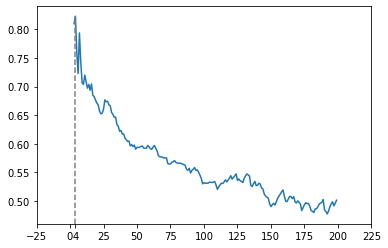

In [31]:
sqr_spike_dst = squareform(spike_dst)
sqr_isi_dst = squareform(isi_dst)

ward_spike = cluster.hierarchy.linkage(spike_dst, method='ward')
ward_isi = cluster.hierarchy.linkage(isi_dst, method='ward')

min_qclust = 3
max_qclust = 200

ncls = np.arange(min_qclust, max_qclust, 1)
metric_scores = np.zeros(ncls.shape[0])
for i, t in enumerate(ncls):
    cls_spike = cluster.hierarchy.fcluster(ward_spike, t=t, criterion='maxclust')
    cls_isi = cluster.hierarchy.fcluster(ward_isi, t=t, criterion='maxclust')
    metric_scores[i] = metrics.adjusted_mutual_info_score(cls_isi, cls_spike)
    
max_cls = np.argmax(metric_scores) + min_qclust
fig, ax = plt.subplots()
ax.plot(ncls, metric_scores)

ax.axvline(max_cls, ymin=0, ymax=(np.max(metric_scores) - ax.get_ylim()[0]) / np.diff(ax.get_ylim()),
           linestyle='--', color='gray')
if max_cls not in list(ax.get_xticks()):
    ax.set_xticks(list(ax.get_xticks()) + [max_cls])
print('Optimum clusters: {}'.format(max_cls))
fig.savefig('{}/mutual_inf.png'.format(cls_folder))

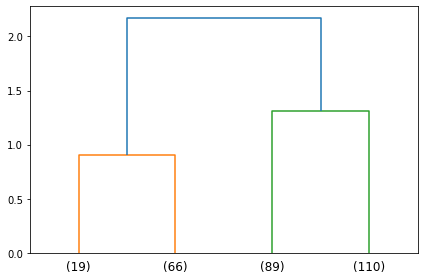

In [32]:
n_cluster = max_cls
cls_spike = cluster.hierarchy.fcluster(ward_spike, t=n_cluster, criterion='maxclust')
fig = plt.figure()
dn = cluster.hierarchy.dendrogram(ward_spike, p=np.unique(cls_spike).shape[0], distance_sort='ascending',
                                  truncate_mode='lastp')
plt.tight_layout()
fig.savefig('{}/dendogram.png'.format(cls_folder))

## REVISAR GUARDADO POR TIPO DE CÉLULA: 1 archivo general o por tipo de célula?

In [41]:
np.array(chirp_psth[0])

array([[ 1.4667494 ,  1.47236945,  1.47715687, ...,  1.12350639,
         1.04517936,  0.96518707],
       [12.29346154, 12.5876023 , 12.92412857, ..., 12.31457991,
        12.51827275, 12.71089493],
       [ 1.53674776,  1.56285432,  1.58791308, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 8.44737668,  8.55500256,  8.65712197, ..., 13.7046902 ,
        13.98790276, 14.28016166],
       [ 0.        ,  0.        ,  0.        , ...,  2.94164555,
         2.98438096,  3.02506417],
       [ 5.29201285,  5.43590495,  5.57503774, ..., 11.19983393,
        11.29818186, 11.38701115]])

In [42]:
np.save('{}/exp_{}_id.npy'.format(cls_folder, ctype), np.array(exp_unit[sel])) # RE-CHECK
np.save('{}/clust_result.npy'.format(cls_folder), np.array(cls_spike))

for i in range(1, max_cls + 1):
    if os.path.isdir('{}/{}/{}'.format(cls_folder, ctype, i)) == False:
        os.mkdir('{}/{}/{}'.format(cls_folder, ctype, i))
    
    cls_units = np.asarray(exp_unit[sel], dtype='<U9')[cls_spike == i]
    cls_chirp = np.array(chirp_psth[sel])[cls_spike == i]
    cls_flash = np.array(flash_psth[sel])[cls_spike == i]

    for (uid, chirp, flash) in zip(cls_units, cls_chirp, cls_flash):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(flash_time, flash)
        ax[1].plot(chirp_time, chirp)

        ax[0].set_title('{}, {} flash'.format(uid[0], uid[1]))
        ax[1].set_title('{}, {} chirp'.format(uid[0], uid[1]))
        
        fig.savefig('{}/{}/{}/{} {}.png'.format(cls_folder, ctype, i, uid[0], uid[1]))
        
        [_ax.clear() for _ax in ax]
        fig.clf()
        fig.clear()
        plt.close()
                
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(flash_time, np.mean(cls_flash, axis=0))
    ax[1].plot(chirp_time, np.mean(cls_chirp, axis=0))
    ax[0].set_title('Mean flash')
    ax[1].set_title('Mean chirp')
    
    fig.savefig('{}/{}/{}/clust{}_mean_resp.png'.format(cls_folder, ctype, i, i))
    
    [_ax.clear() for _ax in ax]
    fig.clf()
    fig.clear()
    plt.close()

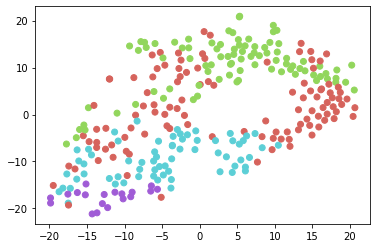

In [44]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
# ax.plot(np.array(list(chirp_psth.values()))[0])

model = TSNE(n_components=2, random_state=0, perplexity=30)#,init='pca')
proj = model.fit_transform(np.array(chirp_psth[sel]))

n_flat_clusters = np.unique(cls_spike).shape[0]
show_order = np.unique(cls_spike)[::-1] - 1

ax.scatter(proj[:, 0], proj[:, 1], c=show_order[cls_spike - 1],
           cmap=ListedColormap(sns.hls_palette(n_flat_clusters, l=0.6, s=0.6).as_hex()))
fig.savefig('{}/{}/tsne.png'.format(cls_folder, ctype))